<header>
    <h1> Physics 152 Project </h1>
</header>

<h2> Section I: Introduction </h2>
<p style="color:Green;"> Write project proposal here </p style="color:Green;">

My dataset captures a strong lensing system with a central galaxy whose dark matter mass model has been set. If there is a source of light behind the central galaxy, the light from the source will bend and appear at a different location for an observer on earth (called the image points). Once the mass model and the image points are known, the positions of the source points can be numerically calculated by solving for the <a href="https://en.wikipedia.org/wiki/Gravitational_lensing_formalism"> deflection angle </a> which is an integral expression. The inputs here are chosen to be random uniformly distributed image points and the true outputs are the numerically solved source points for these images.


<h2> Section II: Data </h2>

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from tqdm import tqdm

import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# I will be using a csv file for my data

df_original = pd.read_csv('MLdata.csv')
df_original.columns = df_original.columns.str.replace(' ', '')
df = df_original.sort_values(by=['img_train_x'])
df_original

,img_train_x,img_train_y,src_train_x,src_train_y,img_test_x,img_test_y,src_test_x,src_test_y
0,7.858767,-8.554427,-1.113931,2.603239,-16.540898,3.366577,0.812498,-2.553141
1,-10.925942,2.052591,4.405556,-3.207238,-1.089924,8.104905,1.490085,-9.140212
2,8.778759,-3.075742,-2.364317,-2.211728,-1.535758,16.440244,0.078532,-5.788795
3,19.230568,7.393190,3.156495,-5.854869,-18.675542,10.046276,-2.481023,-2.317718
4,-0.762724,-4.315299,4.376730,1.882654,0.046374,-8.374269,4.029644,5.108333
...,...,...,...,...,...,...,...,...
9995,2.285836,-13.642959,3.274724,5.567833,NaN,NaN,NaN,NaN
9996,0.941036,8.989345,0.985249,-9.046913,NaN,NaN,NaN,NaN
9997,14.611054,11.912789,2.078535,-6.236964,NaN,NaN,NaN,NaN
9998,-14.915393,-2.197066,2.337259,-0.912701,NaN,NaN,NaN,NaN


In this dataframe every two columns represent an input (images) or an output (sources). Therefore, there are a 1000 training data points that have 2 input features and 2 output features which corresponds to each image position and source position having an x and y coordinate. There are a 100 test data points (values for index >= 100 are given as null/NaN). The input data set has been taken from a uniform distribution on the range of -20 to 20, therefore, it does not need to be rescaled as all the values fall within a close range of each other. As shown below:

In [15]:
img_train_x = df_original.iloc[:, 0]
img_train_y = df_original.iloc[:, 1]

src_train_x = df_original.iloc[:, 2]
src_train_y = df_original.iloc[:, 3]

#showing the max and min of the training data
print(f'Training x max: {max(img_train_x)}')
print(f'Training x min: {min(img_train_x)}')

print(f'Training y max: {max(img_train_y)}')
print(f'Training y min: {min(img_train_y)}')

Training x max: 19.985253154468936
Training x min: -19.996724495453293
Training y max: 19.995602581839957
Training y min: -19.997286467509


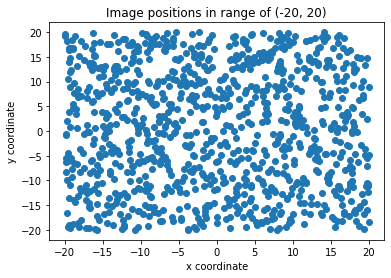

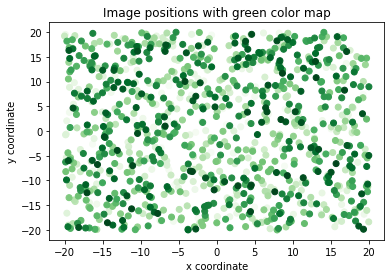

In [16]:
# plotting inputs of the training data up to a 1000 values (more than 1000 makes the plot cluttered)

xplt_img = img_train_x[0 : 999]
yplt_img = img_train_y[0 : 999]

plt.scatter(xplt_img, yplt_img)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Image positions in range of (-20, 20)')
plt.show()

plt.scatter(xplt_img, yplt_img, c=np.arange(0.5, 1.5, 1/len(xplt_img)), cmap='Greens') 
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Image positions with green color map')
plt.show()

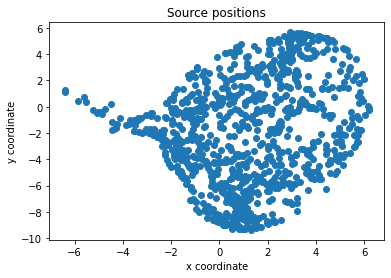

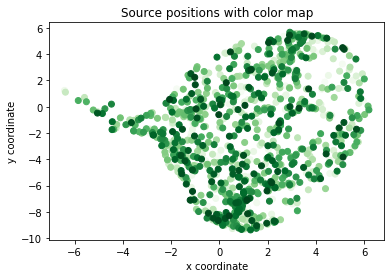

In [17]:
# plotting outputs of training data

xplt_src = src_train_x[0: 999]
yplt_src = src_train_y[0: 999]

plt.scatter(xplt_src, yplt_src)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Source positions')
plt.show()

plt.scatter(xplt_src, yplt_src, c=np.arange(0, 1, 1/len(xplt_src)), cmap='Greens') 
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Source positions with color map')
plt.show()

Creating torch tensors for the training.

In [18]:
img_train = np.array(df_original[['img_train_x', 'img_train_y']].values.tolist())
src_train = np.array(df_original[['src_train_x', 'src_train_y']].values.tolist())
img_test = np.array(df_original[['img_test_x', 'img_test_y']].values.tolist())
src_test = np.array(df_original[['src_test_x', 'src_test_y']].values.tolist())

#removing NaN values from test arrays
img_test = img_test[np.isfinite(img_test)]
img_test = img_test.reshape(-1, 2)
src_test = src_test[np.isfinite(src_test)]
src_test = src_test.reshape(-1, 2)

# sending to gpu

# img_trainT = torch.tensor(img_train, dtype=torch.float).to(device)
# src_trainT = torch.tensor(src_train, dtype=torch.float).to(device)
# img_testT = torch.tensor(img_test, dtype=torch.float).to(device)
# src_testT = torch.tensor(src_test, dtype=torch.float).to(device)

In [19]:
# scaling the values down to get lower loss values

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

img_train = sc.fit_transform(img_train)
img_test = sc.fit_transform(img_test)

src_train = sc.fit_transform(src_train)
src_test = sc.fit_transform(src_test)

img_trainT = torch.tensor(img_train, dtype=torch.float).to(device)
src_trainT = torch.tensor(src_train, dtype=torch.float).to(device)
img_testT = torch.tensor(img_test, dtype=torch.float).to(device)
src_testT = torch.tensor(src_test, dtype=torch.float).to(device)

<h2> Section III: Neural Network </h2>


<p style="color:Green"> Explain why the NN has the structure it does: how many inputs/outputs, how many hidden layers, etc.  How does this structure align with what you're trying to do with the data? </p>
The neural network will have about 1500 to 1600 parameters that includes non linear activation functions in the middle layers and ends with a tanh activation function. Ending with a tanh activation function might be the best choice as the final outputs have both negative and positive values. Furthermore, 

In [20]:
# creating network 
net = torch.nn.Sequential(torch.nn.Linear(2, 30),
                          torch.nn.ReLU(),
                           torch.nn.Linear(30, 40), #torch.nn.Linear(30, 40),
                           torch.nn.ReLU(),
                           torch.nn.Linear(40, 2),
                          torch.nn.Tanh()
                         )

net.to(device)

torch.save(net.state_dict(), 'net.pth') # saving the network

params = np.sum([np.prod(theta.shape) for theta in net.parameters()])
print(f'Number of parameters: {params}')

Number of parameters: 1412


<h2> Section IV: Parameters </h2>

<p style="color:Green"> Choose some reasonable hyperparameters, and explain your choices.  What loss function do you use, and why?  How do your learning rate and batch sizes relate to each other?  How many epochs do you run for? </p>
    
The choice for the loss function is the MSEloss as we want to minimize the distance between the predicted source positions and the true source positions. 

In [21]:
loss_fn = torch.nn.MSELoss()

# SDG and Adam optimizers to compare
optimizer1 = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer2 = torch.optim.Adam(net.parameters(), lr=0.01)

# creating the minibatch loader
img_src_train = torch.utils.data.TensorDataset(img_trainT, src_trainT)
loader = torch.utils.data.DataLoader(img_src_train, batch_size=500, shuffle=True)

<h2> Section V: Execution </h2>

<p style="color:Green">Run the NN on the data and get some loss curves for training and test data.  Display those curves in a plot, and comment on the results.  Are there any signs of overtraining?  Could you have run longer and improved the results? </p>

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.53it/s]


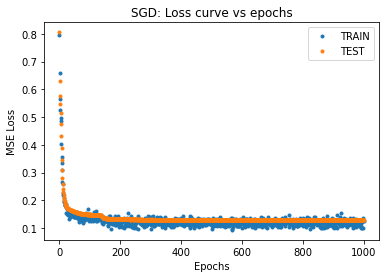

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:29<00:00, 11.17it/s]


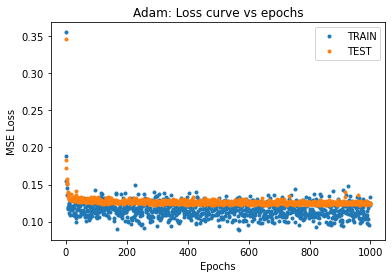

In [22]:
# creating a function that runs the loop given the optimizer

def runNN(optimizer, batch_size=500):

    loader = torch.utils.data.DataLoader(img_src_train, batch_size=batch_size, shuffle=True)
    
    loss_train, loss_test = [], [] # arrays to plot differences in losses

    torch.manual_seed(123)
    net.load_state_dict(torch.load('net.pth'))

    for epoch in tqdm(range(1000)):
        net.train()
    
        for img_batch, src_batch in loader:
            # training the model
            src_pred = net(img_batch) 
            loss_tr = loss_fn(src_pred, src_batch)
            optimizer.zero_grad()
            loss_tr.backward()
            optimizer.step()
        loss_train.append(loss_tr.cpu().data)
    
        # evaluating the model
        net.eval()
        src_pred_test = net(img_testT)
        loss_te = loss_fn(src_pred_test, src_testT)
        loss_test.append(loss_te.cpu().data)

#     if pltLoss:
#         plt.plot(loss_train, '.', label='TRAIN')
#         plt.plot(loss_test, '.', label='TEST')
#         plt.legend()
#         plt.ylabel('MSE Loss')
#         plt.xlabel('Epochs')
#         plt.title('Loss curve vs epochs')
#         plt.show()
    return loss_train, loss_test

loss_train, loss_test = runNN(optimizer1)
plt.plot(loss_train, '.', label='TRAIN')
plt.plot(loss_test, '.', label='TEST')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.title('SGD: Loss curve vs epochs')
plt.show()


loss_train, loss_test = runNN(optimizer2)
plt.plot(loss_train, '.', label='TRAIN')
plt.plot(loss_test, '.', label='TEST')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.title('Adam: Loss curve vs epochs')
plt.show()

<h2> Section VI: Results </h2>


<p style="color:Green"> Evaluate the performance of the model.  If you're doing binary classification, produce a ROC curve.  If you're doing multi-class classification, make a confusion matrix.  If you're doing regression, evaluate the accuracy, bias, and variance of the model predictions.  Connect the results back to the physics problem you're trying to solve. </p>

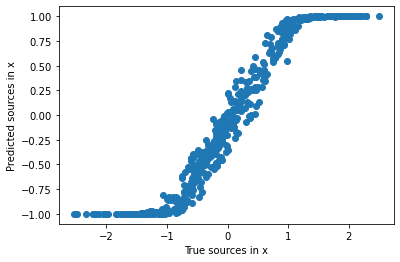

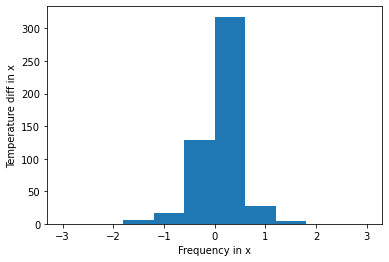

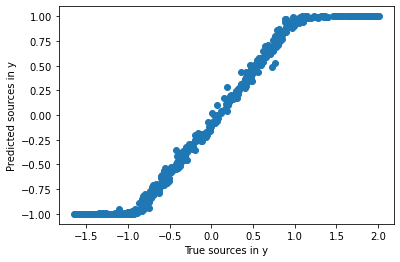

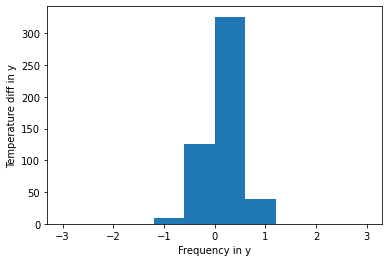

Bias = 0.39171338081359863
Variance = 0.09727249294519424
Standard deviation = 0.3118853843083934


In [23]:
net.eval()
src_pred = net(img_testT).cpu().data

diff = np.array(src_testT.cpu() - src_pred)
dist = np.linalg.norm(diff, axis=1)

# src_x plots

plt.scatter(src_testT.cpu()[:, 0], src_pred[:, 0])
plt.xlabel('True sources in x')
plt.ylabel('Predicted sources in x')
plt.show()


plt.hist(diff[:, 0],range=[-3,3])
plt.xlabel('Frequency in x')
plt.ylabel('Temperature diff in x')
plt.show()


#src_y plots

plt.scatter(src_testT.cpu()[:, 1], src_pred[:, 1])
plt.xlabel('True sources in y')
plt.ylabel('Predicted sources in y')
plt.show()

plt.hist(diff[:, 1],range=[-3,3])
plt.xlabel('Frequency in y')
plt.ylabel('Temperature diff in y')
plt.show()

print(f'Bias = {np.mean(dist)}')
print(f'Variance = {np.var(dist)}')
print(f'Standard deviation = {np.var(dist)**0.5}')

<h2> Section VII: Optimization </h2>

<p style="color:Green"> Do some form of hyperparameter optimization.  Scan over different values of the learning rate, batch size, # of epochs, network architecture, or any other model parameters you choose.  Evaluate something about the model to determine the "best" set of hyperparameters.  (You could look at the test loss, or the accuracy, or other things.) </p>

I will be at the test losses produced due to different learning rates, momentums and batch sizes.

  0%|▏                                                                                | 2/1000 [00:00<01:21, 12.20it/s]

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.80it/s]


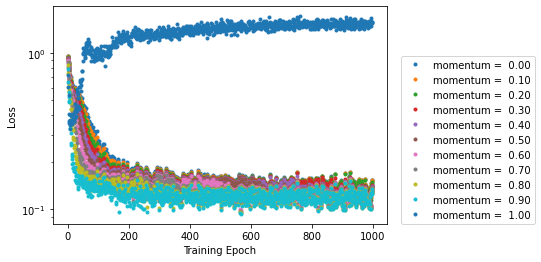

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

The best momentum is 0.9
[0.01 0.06 0.11 0.16 0.21 0.26 0.31 0.36 0.41 0.46 0.51]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.74it/s]


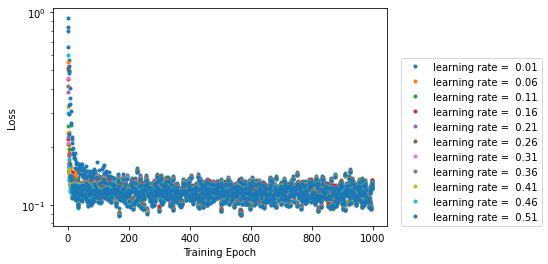

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Most learning rates appear good
[ 500  750 1000 1250 1500 1750 2000 2250 2500 2750 3000 3250 3500 3750
 4000 4250 4500 4750 5000]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.31it/s]


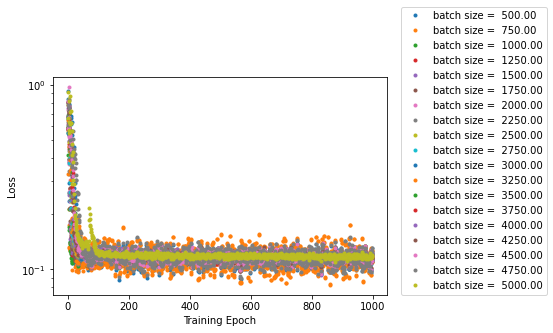

Most batch sizes appear good


In [24]:
# I will be comparing taking the value of the learning rate, momentum or batch size that minimizes the training loss    

# Scanning over different momentum 

momentum_arr = np.arange(0, 1.1, 0.1)
print(momentum_arr)
p_best = 0
lowestLoss = 0
for p in momentum_arr:
    train_loss, test_loss = runNN(torch.optim.SGD(net.parameters(), lr=0.01, momentum=p))
    if p == 0:
        lowestLoss = train_loss[-1]
    if lowestLoss > train_loss[-1]:
        p_best = p
    plt.plot(train_loss, '.', label=f'momentum = {p: .2f}')
    plt.legend(loc=(1.04, 0))
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
plt.show()

print(f'The best momentum is {p_best}')
    
# Scanning over different learning rate

learning_rates = np.arange(0.01, 0.52, 0.05)
print(learning_rates)
lr_best = 0.01
lowestLoss = 0
for lr in learning_rates:
    train_loss, test_loss = runNN(torch.optim.SGD(net.parameters(), lr=lr, momentum=p_best))
    if lr == 0.01:
        lowestLoss = train_loss[-1]
    if lowestLoss > train_loss[-1]:
        lr_best = lr
    plt.plot(train_loss, '.', label=f'learning rate = {lr: .2f}')
    plt.legend(loc=(1.04, 0))
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
plt.show()

# print(f'The best learning rate is {lr_best}')
print('Most learning rates appear good')

# Scanning over different batch size

batch_sizes = np.arange(500, 5001, 250)
print(batch_sizes)
batch_best = 0.01
lowestLoss = 0
for batch in batch_sizes:
    train_loss, test_loss = runNN(torch.optim.SGD(net.parameters(), lr=lr_best, momentum=p_best), batch_size=int(batch))
    if int(batch) == 500:
        lowestLoss = train_loss[-1]
    if lowestLoss > train_loss[-1]:
        batch_best = batch
    plt.plot(train_loss, '.', label=f'batch size = {batch: .2f}')
    plt.legend(loc=(1.04, 0))
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
plt.show()

# print(f'The best batch size is {batch_best}')
print('Most batch sizes appear good')